https://deep-learning-study.tistory.com/368


Lenet-5는 패턴인식에서 이용되는 hadn-designed feature extractor로 특징을 추출, FC multi-layer networks를 분류기로 사용할 때 나타내는 문제점인
1.hand_designed feature extractor의 제한된 특징만을 추출하는 것, 2. 너무 많은 매개변수를 포함하는 것, 3. 입력값의 topology가 무시되는 점을 보완하기 위해 생김

***CNN의 아이디어***

1. recepive field : conner, edge, endpoint를 추출

2. shared weight : 가중치 배열을 강제로 복제함으로 자동으로 shift 불변성을 얻음
- weight을 공유하면 parameter의 수가 느는 것이 아닌 feature map의 수또한 증가함. 이는 계산 capacity를 줄이고, 학습할 parameter의 수를 줄임으로 인해 overfitting을 방지 + test error and training error의 gap또한 줄임
3. Sub-sampling : average pooling was used.

LeNet-5의 구조
32x32의 흑백 이미지로 학습된 7layer CNN

[conv(c1) - Subsampling(S2) - Conv(C3) - Subsampling(S4) - Conv(C5) - Fc - FC]

1. input : 32x32
2. C1 : 5x5, 6kernel, stride=1
- input : 32x32x1 / output : 28x28x6
3. S2 : 2x2, 6kernel, stride=2
- input : 28x28x6, output : 14x14x6
4. C3 : 5x5, 16 kernel, stride=6
- input : 14x14x6, output : 10x10x16
5. L4 : 2x2, 16 kernel, stride=2
- input : 10x10x16, output : 5x5x16
6. C5 : 5x5, 120 kernel, stride=1
- input : 5x5x16, output : 1x1x120
7. F6 : activation function : tanh
- input : 120, output : 84
8. F7 : activation function : RBF(Radial Basis Function)
- 84, 10
- 10 output means it used MNIST data.



*RBF : Gaussian kernel that projection to infinite dimension

https://happycontrol.tistory.com/entry/RBFRadial-Basis-Function-%EC%8B%A0%EA%B2%BD%EB%A7%9D-1




#Modeling with pytorch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# direc = '/content/drive/MyDrive/주피터_대피소/kaggle&github/pytorch/'



In [ ]:
import numpy as np
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

setting parameter

In [ ]:
random_seed = 42
learning_rate = 0.001
batch_size = 32
n_epochs=15

img_size = 32
n_classes = 10

function with acc & visualize loss

.eval() : train과 eval에서 수행하는 다른 작업을 수행할 수 있도록 switching하는 함수

_ : 인터프리터, 값무시, 네이밍, 국제화(지역화), 자릿수 구분자

In [ ]:
def get_accuracy(model, data_loader, device) :
  '''전체 data_loader에 대한 예측의 정확도를 계산하는 함수'''

  correct_pred = 0
  n=0

  with torch.no_grad() :
    model.eval()
    for X,y_true in data_loader : 

      X= X.to(device)
      y_true = y_true.to(device)

      _, y_prob = model(X)
      _, predicted_labels = torch.max(y_prob, 1)

      n += y_true.size(0)
      correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses) :
  '''training과 validation loss를 시각화하는 함수'''
  plt.style.use('seaborn')

  train_loss = np.array(train_losses)
  valid_loss = np.array(valid_losses)

  fig, ax = plt.subplots(figsize=(8,4.5))

  ax.plot(train_losses, color='blue', label = 'Training loss')
  ax.plot(valid_losses, color='red', label = 'Validation Loss')
  ax.set(title='Loss and epochs',
         xlabel = 'Epoch',
         ylabel = 'Loss')
  ax.legend()
  fig.show()
  #plot style을 기본값으로 설정
  plt.style.use('default')

Training data에 사용되는 helper 함수 정의

여기서 loss = evaluation method

running_loss = loss_function

epoch_loss = cost_function

In [ ]:
def train(train_loader, model, criterion, optimizer, device) :
  '''Training loop의 Training 단계에 대한 함수'''

  model.train()
  running_loss = 0

  for x,y_true in train_loader : 

    optimizer.zero_grad()
    #gradient reset

    x=x.to(device)
    y_true = y_true.to(device)

    #순전파
    y_hat, _ = model(x)
    loss = criterion(y_hat, y_true)
    running_loss += loss.item() * x.size(0)

    #역전파
    loss.backward()
    optimizer.step()

  epoch_loss = running_loss / len(train_loader.dataset)
  return model, optimizer, epoch_loss

Validation data에 사용되는 함수 정의

*validation에서는 역전파를 진행하지 않음

In [ ]:
def validate(valid_loader, model, criterion, device) :
  '''training loop의 validation 단계에 대한 함수'''

  model.eval()
  running_loss =0

  for x,y_true in valid_loader :

    x=x.to(device)
    y_true = y_true.to(device)

    #순전파와 손실 기록
    y_hat, _ = model(x)
    loss = criterion(y_hat, y_true)
    running_loss += loss.item()*x.size(0)

  epoch_loss= running_loss / len(valid_loader.dataset)

  return model, epoch_loss

Training loop 정의

In [ ]:
def training_loop(model, 
                  criterion, 
                  optimizer, 
                  train_loader, valid_loader, 
                  epochs, device, print_every=1) :
  '''전체 training loop를 정의 '''

  #metrics를 저장하기 위한 객체 설정
  best_loss = 1e10
  train_losses = []
  valid_losses = []

  #train model
  for epoch in range(0, epochs) :
    
    #training
    model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
    train_losses.append(train_loss)

    #validation
    with torch.no_grad() : 
      model, valid_loss = validate(valid_loader, model, criterion, device)
      valid_losses.append(valid_loss)
    
    if epoch % print_every == (print_every -1) :

      train_acc = get_accuracy(model, train_loader, device=device)
      valid_acc = get_accuracy(model, valid_loader, device=device)

      print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

  plot_losses(train_loss, valid_loss)

  return model, optimizer, (train_loss, valid_loss)



Prepare Dataset

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



Text(0.5, 0.98, 'MNIST Dataset - preview')

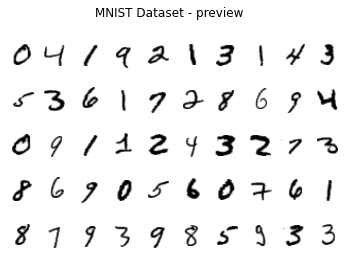

In [ ]:
#transform 정의

transforms = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()])

#dataset 다운받고 생성
train_dataset = datasets.MNIST(root='mnist_data', train=True, transform=transforms, download=True)

valid_dataset = datasets.MNIST(root='mnist_data', train=False, transform=transforms)

#data loader 정의
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

#불러온 MNIST data 확인
row_img = 10
n_rows = 5

fig = plt.figure()
for index in range(1, row_img * n_rows +1) :
  plt.subplot(n_rows, row_img, index)
  plt.axis('off')
  plt.imshow(train_dataset.data[index], cmap='gray_r')
fig.suptitle('MNIST Dataset - preview')

Lenet-5 구조 정의

In [ ]:
class LeNet5(nn.Module) : 

  def __init__(self,n_classes) : 
    super(LeNet5, self).__init__()

    #Convnet
    self.feature_extractor = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2),
        nn.Conv2d(in_channels=16, out_channels =120, kernel_size=5, stride=1),
        nn.Tanh())
    
    #FC
    self.classifier = nn.Sequential(
        nn.Linear(in_features=120, out_features = 84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=n_classes)
    )
    
  def forward(self, x) :
    x= self.feature_extractor(x)
    x= torch.flatten(x,1)
    logits = self.classifier(x)
    probs = F.softmax(logits, dim=1)
    return logits,probs

model, optimizer, loss function  설정

In [ ]:
torch.manual_seed(random_seed)

model = LeNet5(n_classes).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

신경망 학습

In [ ]:
model, optimizer , _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, n_epochs, DEVICE)

11:28:26 --- Epoch: 0	Train loss: 0.2290	Valid loss: 0.1020	Train accuracy: 96.84	Valid accuracy: 96.81
11:29:18 --- Epoch: 1	Train loss: 0.0762	Valid loss: 0.0619	Train accuracy: 98.39	Valid accuracy: 98.19
11:30:07 --- Epoch: 2	Train loss: 0.0550	Valid loss: 0.0542	Train accuracy: 98.59	Valid accuracy: 98.45
11:30:55 --- Epoch: 3	Train loss: 0.0438	Valid loss: 0.0486	Train accuracy: 99.07	Valid accuracy: 98.41
11:31:43 --- Epoch: 4	Train loss: 0.0343	Valid loss: 0.0416	Train accuracy: 99.25	Valid accuracy: 98.76
11:32:31 --- Epoch: 5	Train loss: 0.0298	Valid loss: 0.0433	Train accuracy: 99.36	Valid accuracy: 98.67
11:33:23 --- Epoch: 6	Train loss: 0.0245	Valid loss: 0.0417	Train accuracy: 99.48	Valid accuracy: 98.75


KeyboardInterrupt: ignored